In [115]:
import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from collections import defaultdict
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 10)

# Model imports
import patsy
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [116]:
with open('target_variable.pickle','rb') as f:
    target = pickle.load(f)

In [117]:
with open('features_initial.pickle','rb') as f2:
    features = pickle.load(f2)

In [118]:
target['high_incidence'] = np.nan

In [119]:
cdc_cutoff = 10/100000

In [120]:
target.high_incidence[target.incidence_rate > cdc_cutoff] = 1

/Users/tcbon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [121]:
target.loc[:,'high_incidence'][target.incidence_rate <= cdc_cutoff] = 0

/Users/tcbon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [122]:
target.high_incidence.value_counts()/len(target)

0.0    0.859375
1.0    0.140625
Name: high_incidence, dtype: float64

In [123]:
target

,STNAME,CTYNAME,year,incidence_rate,high_incidence
0,Alabama,Autauga County,2010,0.000000,0.0
1,Alabama,Baldwin County,2010,0.000000,0.0
2,Alabama,Barbour County,2010,0.000000,0.0
3,Alabama,Bibb County,2010,0.000000,0.0
4,Alabama,Blount County,2010,0.000000,0.0
...,...,...,...,...,...
25531,Wyoming,Teton County,2017,0.000086,0.0
25532,Wyoming,Uinta County,2017,0.000000,0.0
25533,Wyoming,Washakie County,2017,0.000000,0.0
25534,Wyoming,Weston County,2017,0.000000,0.0


In [124]:
features

,state,county,DATE,LATITUDE,LONGITUDE,ELEVATION,precip_num_days_over_0.01,precip_num_days_over_0.1,precip_num_days_over_1,snow_depth_num_days_over_1,snowfall_num_days_over_1,max_temp_num_days_under_0,min_temp_num_days_under_32,max_temp_num_days_under_32,max_temp_num_days_over_70,max_temp_num_days_over_90,min_temp_year,max_snow_depth_year,max_snowfall_year,max_precip_day,max_temp_year,first_min_temp_under_32,first_min_temp_under_28,first_min_temp_under_24,first_min_temp_under_20,first_min_temp_under_16,last_min_temp_under_32,last_min_temp_under_28,last_min_temp_under_24,last_min_temp_under_20,last_min_temp_under_16,total_precip_year,total_snowfall_year,avg_daily_temp_year,avg_daily_max_temp,avg_daily_min_temp
0,Alabama,Autauga County,2010,32.482500,-86.485400,100.300000,120.000000,62.000000,14.000000,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,102.100000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1141.700000,35.05744,17.552706,23.943332,11.181082
1,Alabama,Autauga County,2013,32.825200,-86.416400,107.300000,91.000000,74.000000,20.000000,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,84.800000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1590.100000,35.05744,17.552706,23.943332,11.181082
2,Alabama,Autauga County,2014,32.653850,-86.450900,103.800000,106.000000,74.500000,16.500000,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,96.500000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1342.300000,35.05744,17.552706,23.943332,11.181082
3,Alabama,Baldwin County,2010,30.521877,-87.796877,31.723077,111.090909,75.909091,21.000000,0.000000,0.000000,0.000000,47.200000,0.000000,253.000000,95.000000,-8.840000,0.000000,0.000000,91.172727,38.700000,-0.660000,-2.900000,-4.850000,-6.700000,-9.526784,-1.200000,-2.720000,-5.080000,-9.400000,-9.766667,1497.054545,0.00000,18.848000,24.846000,12.854000
4,Alabama,Baldwin County,2011,30.516725,-87.801650,29.991667,95.300000,64.500000,14.100000,0.673203,0.476935,0.000000,21.666667,0.000000,280.000000,97.250000,-5.933333,22.512255,25.230208,95.080000,38.600000,-1.400000,-2.500000,-5.256631,-7.443868,-9.526784,-2.033333,-2.766667,-4.600000,-6.700000,-10.532082,1218.360000,35.05744,20.060000,26.047500,14.013333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22218,Wyoming,Weston County,2013,43.862167,-104.547033,1315.100000,76.333333,42.333333,3.000000,98.500000,25.000000,20.000000,203.000000,47.000000,131.000000,27.000000,-28.900000,343.000000,304.500000,49.533333,37.200000,0.000000,-2.200000,-5.600000,-8.900000,-8.900000,-0.600000,-3.900000,-6.100000,-13.300000,-13.300000,488.333333,1888.50000,7.060000,14.130000,-0.010000
22219,Wyoming,Weston County,2014,43.862167,-104.547033,1315.100000,68.333333,37.666667,1.666667,86.500000,19.500000,40.000000,181.000000,60.000000,130.000000,23.000000,-31.700000,304.500000,193.000000,29.200000,38.900000,-0.600000,-8.900000,-8.900000,-8.900000,-8.900000,-2.800000,-2.800000,-5.600000,-7.200000,-10.000000,330.266667,1283.00000,6.690000,14.010000,-0.630000
22220,Wyoming,Weston County,2015,43.862167,-104.547033,1315.100000,71.666667,36.333333,1.333333,39.000000,9.000000,14.500000,160.500000,39.000000,137.500000,22.000000,-24.700000,127.000000,102.000000,29.733333,36.950000,-0.600000,-5.550000,-5.550000,-7.800000,-9.150000,-0.850000,-2.750000,-5.000000,-8.350000,-14.450000,413.266667,513.00000,8.740000,15.575000,1.900000
22221,Wyoming,Weston County,2016,43.862167,-104.547033,1315.100000,60.000000,31.666667,0.000000,48.000000,12.500000,18.000000,163.000000,40.000000,147.000000,41.000000,-31.100000,215.500000,120.500000,19.400000,40.0

In [125]:
df = features.merge(target, left_on=['state','county','DATE'],right_on=['STNAME','CTYNAME','year'])

In [126]:
df = df[df.state != 'Hawaii']

In [133]:
df.high_incidence.value_counts()/ len(df)

0.0    0.857209
1.0    0.142791
Name: high_incidence, dtype: float64

In [128]:
df.drop(columns=['LATITUDE','LONGITUDE','STNAME','CTYNAME','year','incidence_rate'], inplace=True)

In [129]:
df.columns = df.columns.str.replace('.','',)

## Modeling

In [130]:
def ols_formula(df, dependent_var, *excluded_cols):
    '''
    Generates the R style formula for statsmodels (patsy) given
    the dataframe, dependent variable and optional excluded columns
    as strings
    '''
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    for col in excluded_cols:
        df_columns.remove(col)
    return dependent_var + ' ~ ' + ' + '.join(df_columns)

In [131]:
# Using patsy to set up data for modeling
formula = ols_formula(df,'high_incidence','county','state','DATE')
y, X = patsy.dmatrices(formula, data=df, return_type="dataframe")

In [132]:
X

,Intercept,ELEVATION,precip_num_days_over_001,precip_num_days_over_01,precip_num_days_over_1,snow_depth_num_days_over_1,snowfall_num_days_over_1,max_temp_num_days_under_0,min_temp_num_days_under_32,max_temp_num_days_under_32,max_temp_num_days_over_70,max_temp_num_days_over_90,min_temp_year,max_snow_depth_year,max_snowfall_year,max_precip_day,max_temp_year,first_min_temp_under_32,first_min_temp_under_28,first_min_temp_under_24,first_min_temp_under_20,first_min_temp_under_16,last_min_temp_under_32,last_min_temp_under_28,last_min_temp_under_24,last_min_temp_under_20,last_min_temp_under_16,total_precip_year,total_snowfall_year,avg_daily_temp_year,avg_daily_max_temp,avg_daily_min_temp
0,1.0,100.300000,120.000000,62.000000,14.000000,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,102.100000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1141.700000,35.05744,17.552706,23.943332,11.181082
1,1.0,107.300000,91.000000,74.000000,20.000000,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,84.800000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1590.100000,35.05744,17.552706,23.943332,11.181082
2,1.0,103.800000,106.000000,74.500000,16.500000,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,96.500000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1342.300000,35.05744,17.552706,23.943332,11.181082
3,1.0,31.723077,111.090909,75.909091,21.000000,0.000000,0.000000,0.000000,47.200000,0.000000,253.000000,95.000000,-8.840000,0.000000,0.000000,91.172727,38.700000,-0.660000,-2.900000,-4.850000,-6.700000,-9.526784,-1.200000,-2.720000,-5.080000,-9.400000,-9.766667,1497.054545,0.00000,18.848000,24.846000,12.854000
4,1.0,29.991667,95.300000,64.500000,14.100000,0.673203,0.476935,0.000000,21.666667,0.000000,280.000000,97.250000,-5.933333,22.512255,25.230208,95.080000,38.600000,-1.400000,-2.500000,-5.256631,-7.443868,-9.526784,-2.033333,-2.766667,-4.600000,-6.700000,-10.532082,1218.360000,35.05744,20.060000,26.047500,14.013333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21786,1.0,1315.100000,76.333333,42.333333,3.000000,98.500000,25.000000,20.000000,203.000000,47.000000,131.000000,27.000000,-28.900000,343.000000,304.500000,49.533333,37.200000,0.000000,-2.200000,-5.600000,-8.900000,-8.900000,-0.600000,-3.900000,-6.100000,-13.300000,-13.300000,488.333333,1888.50000,7.060000,14.130000,-0.010000
21787,1.0,1315.100000,68.333333,37.666667,1.666667,86.500000,19.500000,40.000000,181.000000,60.000000,130.000000,23.000000,-31.700000,304.500000,193.000000,29.200000,38.900000,-0.600000,-8.900000,-8.900000,-8.900000,-8.900000,-2.800000,-2.800000,-5.600000,-7.200000,-10.000000,330.266667,1283.00000,6.690000,14.010000,-0.630000
21788,1.0,1315.100000,71.666667,36.333333,1.333333,39.000000,9.000000,14.500000,160.500000,39.000000,137.500000,22.000000,-24.700000,127.000000,102.000000,29.733333,36.950000,-0.600000,-5.550000,-5.550000,-7.800000,-9.150000,-0.850000,-2.750000,-5.000000,-8.350000,-14.450000,413.266667,513.00000,8.740000,15.575000,1.900000
21789,1.0,1315.100000,60.000000,31.666667,0.000000,48.000000,12.500000,18.000000,163.000000,40.000000,147.000000,41.000000,-31.100000,215.500000,120.500000,19.400000,40.000000,-3.300000,-3.300000,-6.700000,-6.700000,-12.200000,-0.600000,-5.000000,-5.000000,-7.800000,-8.900000,267.533333,817.50000,9.020000,16.440000,1.600000


In [19]:
y = np.array(y).reshape((21759,))

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [77]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(metrics.f1_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.6184092940125112
0.7582130567284332


In [78]:
lr = LogisticRegression(solver='lbfgs',max_iter=1000000,random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(metrics.f1_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.5020661157024794
0.6817148916830783


In [79]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print(metrics.f1_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.5098039215686274
0.7928279450018579


In [80]:
linearsvc = LinearSVC(max_iter=100,random_state=42)
linearsvc.fit(X_train, y_train)
y_pred = linearsvc.predict(X_test)

print(metrics.f1_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.6074895977808599
0.8013302827724885


/Users/tcbon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [81]:
decisiontree = DecisionTreeClassifier(max_depth=9,random_state=42)
decisiontree.fit(X_train, y_train)
y_pred = decisiontree.predict(X_test)

print(metrics.f1_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.6306306306306306
0.7811712461765484


In [82]:
svc = SVC(gamma='scale',random_state=42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(metrics.f1_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.38536585365853665
0.6217196651979262


In [86]:
clf = RandomForestClassifier(n_estimators=1000,random_state=42,verbose=1,n_jobs=-1,)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.f1_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s


0.7450980392156862
0.8254309219314521


[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [87]:
print(metrics.recall_score(y_test, y_pred))

0.6731078904991948


In [88]:
print(metrics.precision_score(y_test, y_pred))

0.8343313373253493


In [84]:
# max_depth = 36
# 0.82543092193145

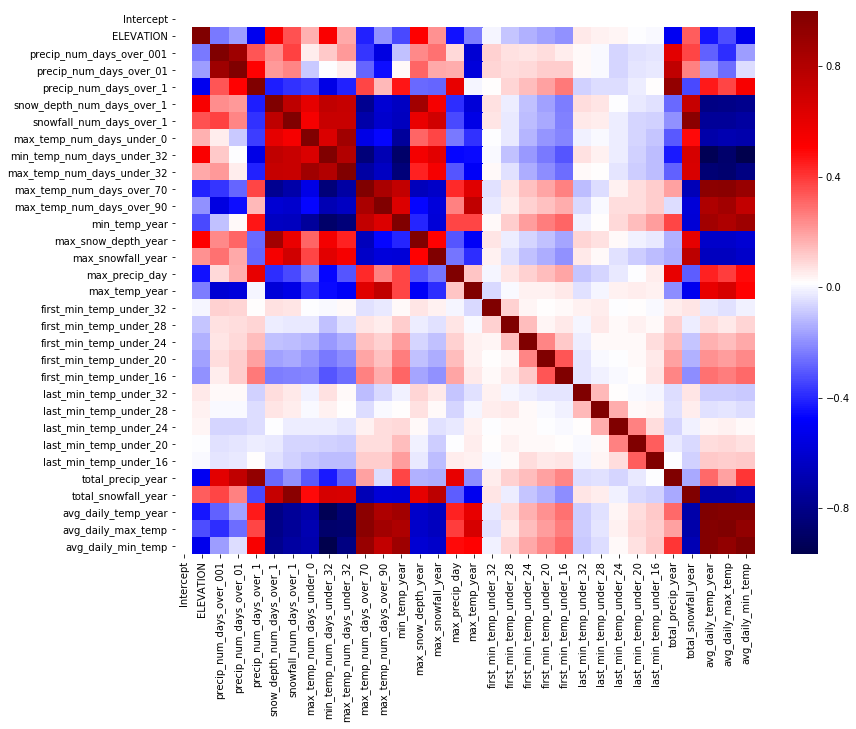

In [28]:
plt.figure(figsize=(13,10))
sns.heatmap(X.corr(), cmap="seismic")

In [29]:
df.corr()[df.corr()> .9]

,ELEVATION,precip_num_days_over_001,precip_num_days_over_01,precip_num_days_over_1,snow_depth_num_days_over_1,snowfall_num_days_over_1,max_temp_num_days_under_0,min_temp_num_days_under_32,max_temp_num_days_under_32,max_temp_num_days_over_70,max_temp_num_days_over_90,min_temp_year,max_snow_depth_year,max_snowfall_year,max_precip_day,max_temp_year,first_min_temp_under_32,first_min_temp_under_28,first_min_temp_under_24,first_min_temp_under_20,first_min_temp_under_16,last_min_temp_under_32,last_min_temp_under_28,last_min_temp_under_24,last_min_temp_under_20,last_min_temp_under_16,total_precip_year,total_snowfall_year,avg_daily_temp_year,avg_daily_max_temp,avg_daily_min_temp,high_incidence
ELEVATION,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precip_num_days_over_001,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precip_num_days_over_01,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precip_num_days_over_1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.917239,NaN,NaN,NaN,NaN,NaN
snow_depth_num_days_over_1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
total_snowfall_year,NaN,NaN,NaN,NaN,NaN,0.961002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
avg_daily_temp_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.951717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.982008,0.980408,NaN
avg_daily_max_temp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.961035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.982008,1.000000,0.926785,NaN
avg_daily_min_temp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.906573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.980408,0.926785,1.000000,NaN
